# 图像半色调(Halftoning)

假设一幅灰度图像，那么我们知道它的每个像素都有一个对应的灰度值，通常这个灰度的取值范围是 0 ~ 255，即 8 bit 灰度级。而半色调技术的意思就是，如图中所示，将灰度级压缩，划分成 10 个灰度级，取值范围是 0 ~ 9。我们想将以前的图像的一个像素，用现在的一个 3 * 3的矩阵表示，它在原图像中的像素值是一个 0 ~ 255 的数， 在 0 ~ 255 内10等分，即像素灰度值除以25.6，则其像素值就会对应图中的某一种情况，那么就用那个矩阵来表示这个像素。比如灰度是 0， 那么那个像素就用图中 0 的情况的矩阵表示。

In [22]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from scipy.misc import imread, imresize, imsave
from scipy.ndimage.interpolation import rotate
from scipy.ndimage import gaussian_filter

In [8]:
src = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [9]:
# size = 256
# # 生成256*256灰度图像
# simple_gray = np.zeros((size,size),dtype=np.uint8)
# for i in range(size):
#     simple_gray[i,:] = (255 - i - 1) * np.ones((1,size))

# plt.imshow(simple_gray,'gray')

In [10]:
# # 基于半色调计数的图像打印
# rows,cols = gray.shape
# #将256灰度级量化成10灰度级别
# qim = np.fix(np.float32(simple_gray) / 25.6)
# new_gray = gray.copy()

# # 调整图像大小
# r_scale = float(rows) / 272
# c_scale = float(cols) / 352

# scale = max(r_scale,c_scale)
# if scale > 1:
#     new_gray = cv2.resize(new_gray,(int(cols * 1.0 / scale),int(rows * 1.0 / scale)))
# cy,cx = new_gray.shape                     

# # 构造点模式，表示10个灰度级
# dot_mat = np.array([[[0,0,0],[0,0,0],[0,0,0]],
# [[0,255,0],[0,0,0],[0,0,0]],
# [[0,255,0],[0,0,0],[0,0,255]],
# [[255,255,0],[0,0,0],[0,0,255]],
# [[255,255,0],[0,0,0],[255,0,255]],
# [[255,255,255],[0,0,0,],[255,0,255]],
# [[255,255,255],[0,0,255,],[255,0,255]],
# [[255,255,255],[0,0,255],[255,255,255]],
# [[255,255,255],[255,0,255],[255,255,255]],
# [[255,255,255],[255,255,255],[255,255,255]]])

# dst = np.zeros((3 * cy,3*cx),np.float32)

# for i in range(1,cy):
#     for j in range(1,cx):
#         level = qim[i,j]
        
#         dst[int((i - 1) * 3 + 1):int(i * 3),int((j - 1) * 3):int(j * 3)] = dot_mat[:,:,level + 1]
# plt.imshow(dst)

In [48]:
def crop_center(img, new_shape):
    """
    Crop an image equally on each size to create the new_shape
        Args:
            img (numpy array): 2D array to crop
            new_shape: desired shape of the return
        Returns:
            numpy array: array cropped according to shape
    """
    ul = ((img.shape[0]-new_shape[0])//2, (img.shape[1]-new_shape[1])//2)
    br = (ul[0]+new_shape[0], ul[1]+new_shape[1])
    return img[ul[0]:br[0], ul[1]:br[1]]

In [30]:
def gauss_kernel(size, sigma=None, size_y=None, sigma_y=None):
    """
    Generates a 2D Gaussian kernel as a numpy array
        Args:
            size (int): 1/2 the width of the kernel; total width := 2*size+1
            sigma (float): spread of the gaussian in the width direction
            size_y (int): 1/2 the height of the kernel; defaults to size
            sigma_y (float): spread of the gaussian in the height direction; defaults to sigma
        Returns:
            numpy array: normalized 2D gaussian array
    """
    size = int(size)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    if not sigma:
        sigma = 0.5 * size + .1
    if not sigma_y:
        sigma_y = sigma
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-0.5 * (x ** 2 / sigma ** 2 + y ** 2 / sigma_y ** 2))
    return g / g.sum()

In [13]:
def resize(a, shape):
    """
    if array a is larger than shape, crop a; if a is smaller than shape, pad a with zeros
        Args:
            a (numpy array): 2D array to resize
            shape: desired shape of the return
        Returns:
            numpy array: array a resized according to shape
    """
    if a.shape[0] < shape[0]:
        a = np.pad(a, ((0, shape[0]-a.shape[0]), (0, 0)), mode="constant")
    if a.shape[1] < shape[1]:
        a = np.pad(a, ((0, 0), (0, shape[1]-a.shape[1])), mode="constant")
    if a.shape[0] > shape[0]:
        a = a[0:shape[0], :]
    if a.shape[1] > shape[1]:
        a = a[:, 0:shape[1]]
    return a

In [14]:
def cmyk_to_rgb(cmyk):
    """
    Converts a cmyk image to a rgb representation
        Args:
            cmyk (numpy array): 0.0-1.0 r x c x 4 image
        Returns:
            numpy array: 0-255 r x c x 3 image
    """
    rgb = 255 * (1.0 - cmyk[:,:,0:3]) * (1 - np.stack([cmyk[:,:,3],cmyk[:,:,3],cmyk[:,:,3]], axis=2))
    return np.round(rgb).astype(np.uint8)

In [15]:
def rgb_to_cmyk(rgb, percent_gray=100):
    """
    Converts an rgb image to a cmyk representation
        Args:
            rgb (numpy array): 0-255 r x c x 3 image
            percent_gray (int): 0-100 percent of K channel to replace in CMY
        Returns:
            numpy array: 0.0-1.0 r x c x 4 image
    """

    cmy = 1 - rgb / 255.0
    k = np.min(cmy, axis=2) * (percent_gray / 100.0)
    k[np.where(np.sum(rgb,axis=2)==0)] = 1.0  # anywhere there is no color, set the k chanel to max
    k_mat = np.stack([k,k,k], axis=2)

    with np.errstate(divide='ignore', invalid='ignore'):
        cmy = (cmy - k_mat) / (1.0 - k_mat)
        cmy[~np.isfinite(cmy)] = 0.0

    return np.dstack((cmy, k))

In [24]:
def halftone(cmyk, size, angles, fill, sharpness):
    """
    Generates a halftone image from a cmyk image
        Args:
            cmyk (numpy array): 0.0-1.0 r x c x 4 image
            size (int): half size of the averaging kernel in pixels
            angles (list of float): 4 angles for the relative rotation of each channel
        Returns:
            numpy array: 0.0-1.0 r x c x 4 halftoned image
    """
    halftone_image = np.zeros(cmyk.shape)

    for i, (channel, angle) in enumerate(zip(np.rollaxis(cmyk, 2), angles)):

        # total width of the kernel
        s = 2 * size + 1

        # rotate the image to eliminate overlap between the channels
        rotated = rotate(channel, angle, reshape=True, prefilter=False, order=1)

        # apply a gaussian filter to average over a the region of the kernel
        averaged = gaussian_filter(rotated, size)

        # find the central value of the filtered image; this is the average intensity in the region
        halftone_weights = averaged[size::s, size::s]

        # tile the weight image with the average intensity value
        halftone_weights = np.repeat(np.repeat(halftone_weights, s, 0), s, 1)
        halftone_weights = resize(halftone_weights, rotated.shape)

        # TODO: consider using sigma to scale with magnitude
        # create a 2D gaussian kernel that will be the "dot"; normalize it to be 1.0 in the center
        kernel = gauss_kernel(size, sigma=fill*size)

        # Apply the sharpness multiplier and clip the kernel to 1.0
        kernel *= sharpness / np.max(kernel)
        kernel = np.clip(kernel, 0.0, 1.0)

        # tile the kernel across the image
        num_kernels = np.array(rotated.shape) // s + 1
        tiled_kernel = np.tile(kernel, num_kernels)
        tiled_kernel = resize(tiled_kernel, rotated.shape)

        # multiply the kernel image with the weights to generate the halftone image
        halftone = tiled_kernel * halftone_weights

        # rotate the image back to zero
        halftone = rotate(halftone, -angle, prefilter=False, order=1)

        # crop the image to the original size
        halftone = crop_center(halftone, channel.shape)

        # add this chanel to the full cmyk image
        halftone_image[:,:,i] = halftone

#        Image.fromarray(halftone*255).show()

#    Image.fromarray(cmyk_to_rgb(halftone_image)).show()

    return halftone_image

In [25]:
CMYK = rgb_to_cmyk(src, 100)

In [73]:
CMYK = halftone(CMYK, 3, [15, 75, 0, 45], 0.5, 1.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


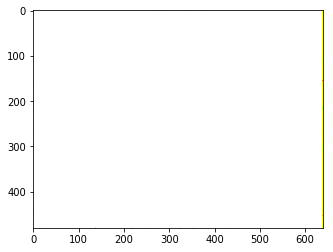

In [74]:
plt.imshow(CMYK)

In [80]:
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageStat as ImageStat
import os

In [95]:
class Halftone(object):

    def __init__(self, path):
        """
        path is the path to the image we want to halftone.
        """
        self.path = path

    def make(self, sample=10, scale=1, percentage=0, filename_addition='_halftoned', angles=[0,15,30,45], style='color', antialias=False):
        """
        Leave filename_addition empty to save the image in place.
        Arguments:
            sample: Sample box size from original image, in pixels.
            scale: Max output dot diameter is sample * scale (which is also the
                number of possible dot sizes)
            percentage: How much of the gray component to remove from the CMY
                channels and put in the K channel.
            filename_addition: What to add to the filename (before the extension).
            angles: A list of 4 angles that each screen channel should be rotated by.
            style: 'color' or 'grayscale'.
            antialias: boolean.
        """
        f, e = os.path.splitext(self.path)

        outfile = "%s%s%s" % (f, filename_addition, e)

        try:
            im = Image.open(self.path)
        except IOError:
            raise

        if style == 'grayscale':
            angles = angles[:1]
            gray_im = im.convert('L')
            dots = self.halftone(im, gray_im, sample, scale, angles, antialias)
            new = dots[0]

        else:
            cmyk = self.gcr(im, percentage)
            dots = self.halftone(im, cmyk, sample, scale, angles, antialias)
            new = Image.merge('CMYK', dots)

        new.save(outfile)
        return new,outfile

    def gcr(self, im, percentage):
        """
        Basic "Gray Component Replacement" function. Returns a CMYK image with
        percentage gray component removed from the CMY channels and put in the
        K channel, ie. for percentage=100, (41, 100, 255, 0) >> (0, 59, 214, 41)
        """
        cmyk_im = im.convert('CMYK')
        if not percentage:
            return cmyk_im
        cmyk_im = cmyk_im.split()
        cmyk = []
        for i in range(4):
            cmyk.append(cmyk_im[i].load())
        for x in range(im.size[0]):
            for y in range(im.size[1]):
                gray = min(cmyk[0][x,y], cmyk[1][x,y], cmyk[2][x,y]) * percentage / 100
                for i in range(3):
                    cmyk[i][x,y] = cmyk[i][x,y] - gray
                cmyk[3][x,y] = gray
        return Image.merge('CMYK', cmyk_im)

    def halftone(self, im, cmyk, sample, scale, angles, antialias):
        """
        Returns list of half-tone images for cmyk image. sample (pixels),
        determines the sample box size from the original image. The maximum
        output dot diameter is given by sample * scale (which is also the number
        of possible dot sizes). So sample=1 will presevere the original image
        resolution, but scale must be >1 to allow variation in dot size.
        """

        # If we're antialiasing, we'll multiply the size of the image by this
        # scale while drawing, and then scale it back down again afterwards.
        # Because drawing isn't aliased, so drawing big and scaling back down
        # is the only way to get antialiasing from PIL/Pillow.
        antialias_scale = 4

        if antialias is True:
            scale = scale * antialias_scale

        cmyk = cmyk.split()
        dots = []

        for channel, angle in zip(cmyk, angles):
            channel = channel.rotate(angle, expand=1)
            size = channel.size[0] * scale, channel.size[1] * scale
            half_tone = Image.new('L', size)
            draw = ImageDraw.Draw(half_tone)

            # Cycle through one sample point at a time, drawing a circle for
            # each one:
            for x in range(0, channel.size[0], sample):
                for y in range(0, channel.size[1], sample):

                    # Area we sample to get the level:
                    box = channel.crop((x, y, x + sample, y + sample))

                    # The average level for that box (0-255):
                    mean = ImageStat.Stat(box).mean[0]

                    # The diameter of the circle to draw based on the mean (0-1):
                    diameter = (mean / 255) ** 0.5

                    # Size of the box we'll draw the circle in:
                    box_size = sample * scale

                    # Diameter of circle we'll draw:
                    # If sample=10 and scale=1 then this is (0-10)
                    draw_diameter = diameter * box_size

                    # Position of top-left of box we'll draw the circle in:
                    # x_pos, y_pos = (x * scale), (y * scale)
                    box_x, box_y = (x * scale), (y * scale)

                    # Positioned of top-left and bottom-right of circle:
                    # A maximum-sized circle will have its edges at the edges
                    # of the draw box.
                    x1 = box_x + ((box_size - draw_diameter) / 2)
                    y1 = box_y + ((box_size - draw_diameter) / 2)
                    x2 = x1 + draw_diameter
                    y2 = y1 + draw_diameter

                    draw.ellipse([(x1, y1), (x2, y2)], fill=255)

            half_tone = half_tone.rotate(-angle, expand=1)
            width_half, height_half = half_tone.size

            # Top-left and bottom-right of the image to crop to:
            xx1 = (width_half - im.size[0] * scale) / 2
            yy1 = (height_half - im.size[1] * scale) / 2
            xx2 = xx1 + im.size[0] * scale
            yy2 = yy1 + im.size[1] * scale

            half_tone = half_tone.crop((xx1, yy1, xx2, yy2))

            if antialias is True:
                # Scale it back down to antialias the image.
                w = (xx2 - xx1) / antialias_scale
                h = (yy2 - yy1) / antialias_scale
                half_tone = half_tone.resize((w, h), resample=Image.LANCZOS)

            dots.append(half_tone)
        return dots

In [96]:
h = Halftone('../datas/f3.jpg')

In [97]:
dst,outfile = h.make()

In [98]:
print(outfile)

../datas/f3_halftoned.jpg


In [99]:
dst = cv2.imread(outfile)

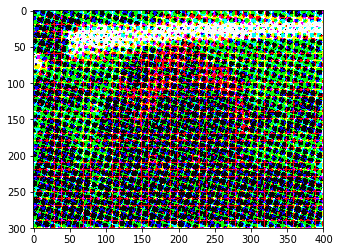

In [101]:
plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))